## **데이터 불러오기**

In [6]:
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url)

In [7]:
df = df.fillna(0)
df.isnull().sum()
df.drop(columns='Unnamed: 0',inplace = True)

In [8]:
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0,0.01
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0,0,0
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03


## **데이터 전처리(지역값 단위 통일)**

단위 : 만

Type : Float

In [9]:
# '지역에 따라서 선호하는 게임 장르가 다를까'
country_sales = df.iloc[:,5:]
country_sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0,0,0
1,0.17,0,0,0.01
2,0,0,0.02,0
3,0.04,0,0,0
4,0.12,0.09,0,0.04
...,...,...,...,...
16593,0.15,0.04,0,0.01
16594,0.01,0,0,0
16595,0.44,0.19,0.03,0.13
16596,0.05,0.05,0.25,0.03


In [10]:
lst = []
def toFloat(column) :
  for i in range(len(column)) :
    data = column[i].lower()
    if data.find('k') != -1 : 
      column[i] = float(data.rstrip('k')) * 0.001
    elif data.find('m') != -1 :
      column[i] = data.rstrip('m')
  return column.astype(float)

def toCount(data) :
  return data*100
country_sales = (country_sales
                 .apply(toFloat)
                 .apply(toCount)
                 .astype(int)
)

In [11]:
country_sales.dtypes

NA_Sales       int64
EU_Sales       int64
JP_Sales       int64
Other_Sales    int64
dtype: object

## **데이터 전처리(연도)**

In [12]:
year = df['Year']
def reset_year(data) :
  if data < 1000 :
    if data == 0 : data
    elif data < 21 : data += 2000
    elif data < 100 : data += 1900
  return int(data)
year = year.apply(reset_year)

## **데이터 합치기(전처리 데이터들 종합)**

In [13]:
df['Year'] = year
df = df.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
df = pd.concat([df, country_sales], axis=1)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,4,0,0,0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,17,0,0,1
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,2,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,4,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,12,9,0,4
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,15,4,0,1
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,1,0,0,0
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,44,19,3,13
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,5,5,25,3


## **지역에 따라서 선호하는 게임 장르가 다를까 ==> 장르와 지역은 상관이 없다**

In [14]:
df_groupby_Genre  = (df
                     .loc[:, ['Genre', 'NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
                     .groupby(by=['Genre'])
                     .sum()
                     .dropna()
)
df_groupby_Genre = df_groupby_Genre[1:].T
df_groupby_Genre

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
NA_Sales,87418,10560,22307,40784,44632,12329,35702,31932,58168,18291,68014,6865
EU_Sales,52182,6405,10112,21222,20153,5072,23695,18348,31283,11330,37628,4529
JP_Sales,15778,5192,8732,10522,13063,5686,5639,34474,3826,6369,13523,4938
Other_Sales,18633,1680,3661,7403,5148,1251,7709,5696,10259,3145,13463,1136


In [15]:
from scipy.stats import chi2_contingency
df_Relation_GenreCountry = chi2_contingency(df_groupby_Genre, correction = False)
df_Relation_GenreCountry

(69642.67327891082,
 0.0,
 33,
 array([[85838.43652972, 11758.62911861, 22105.45320566, 39429.41578553,
         40941.35932912, 12005.76899311, 35884.61111857, 44618.36656368,
         51073.60089041, 19305.02792117, 65424.48557886,  8616.84496555],
        [47526.97302139,  6510.51057641, 12239.33380668, 21831.25480902,
         22668.38678522,  6647.34683092, 19868.56952975, 24704.26990124,
         28278.40009392, 10688.79604848, 36224.18914828,  4770.9694487 ],
        [25091.81550469,  3437.21722296,  6461.74343229, 11525.78805423,
         11967.7510021 ,  3509.45977986, 10489.5904218 , 13042.59335559,
         14929.55163808,  5643.13865087, 19124.52262647,  2518.82831106],
        [15553.77494421,  2130.64308202,  4005.46955537,  7144.54135121,
          7418.50288355,  2175.42439611,  6502.22892987,  8084.77017949,
          9254.4473776 ,  3498.03737949, 11854.80264639,  1561.35727469]]))

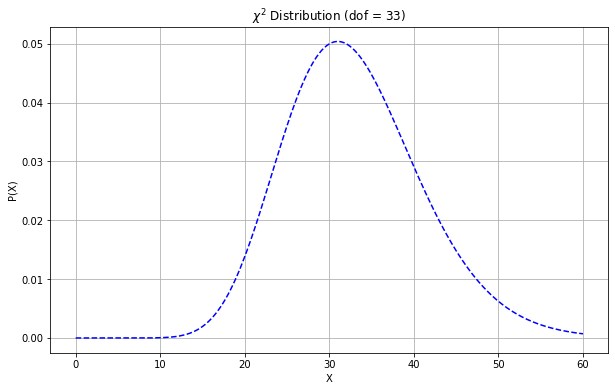

In [16]:
from numpy import linspace
from scipy.stats import chi2
import matplotlib.pyplot as plt

dof = 33         # 자유도
x = linspace(0, 60, 201)
y = chi2(dof).pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (dof = 33)')
plt.show()

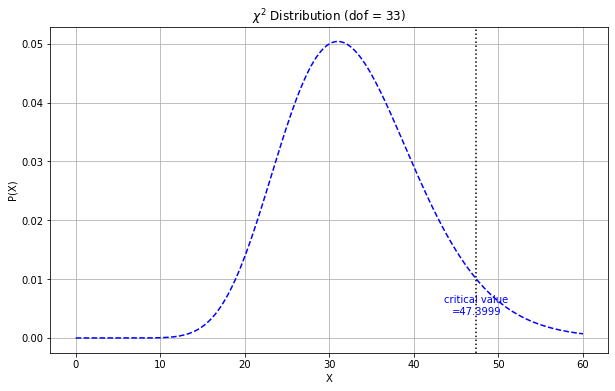

In [17]:
x95 = chi2(dof).ppf(.95)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')

plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .004, 'critical value\n=' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (dof = 33)')
plt.show()

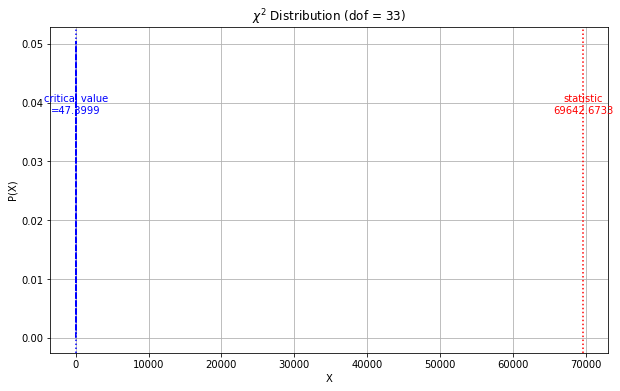

In [18]:
dof = 33          # 자유도
x = linspace(0, 60, 201)
y = chi2(dof).pdf(x)

x95 = chi2(dof).ppf(.95)
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')

plt.axvline(x=x95, color='b', linestyle=':')
plt.text(x95, 0.04, 'critical value\n=' + str(round(x95, 4)),va = 'center_baseline', ha='center', color='b')
plt.axvline(x=df_Relation_GenreCountry[0], color='r', linestyle=':')
plt.text(df_Relation_GenreCountry[0], 0.04, 'statistic\n' + str(round(df_Relation_GenreCountry[0], 4)),va = 'center_baseline', ha='center', color='r')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (dof = 33)')
plt.show()  

## **연도별 게임의 트렌드가 있을까**

In [19]:
df_TotalPerYear = (df
                    .drop(df[ df['Genre'] == 0 ].index) #결측치 제거
                    .drop(df[ df['Year'] == 0 ].index) #결측치 제거
                    .loc[:, ['Genre', 'Year', 'NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
                    .groupby(by=['Genre','Year'])
                    .sum()
)
df_TotalPerYear["Total_Sales"] = df_TotalPerYear.sum(axis=1)
df_TotalPerYear

NA_Sales  EU_Sales  JP_Sales  Other_Sales  Total_Sales
Genre    Year                                                        
Action   1980        32         2         0            0           34
         1981      1385        81         0           12         1478
         1982       604        38         0            5          647
         1983       267        17         0            2          286
         1984        80        19        83            3          185
...                 ...       ...       ...          ...          ...
Strategy 2012        94        99       111           29          333
         2013       239       247        81           64          631
         2014        16        22        55            4           97
         2015        57        97        15           12          181
         2016        11        32         5            4           52

[388 rows x 5 columns]

In [20]:
temp = df_TotalPerYear.pivot_table(values="Total_Sales",index="Year",columns="Genre").fillna(0).astype(int)
BestGenre = temp.idxmax(axis=1)
temp,BestGenre

(Genre  Action  Adventure  Fighting  Misc  ...  Shooter  Simulation  Sports  Strategy
 Year                                      ...                                       
 1980       34          0        77   270  ...      707           0       0         0
 1981     1478          0         0     0  ...     1002          44      78         0
 1982      647          0         0    87  ...      380           0     106         0
 1983      286         40         0   214  ...       49           0     320         0
 1984      185          0         0   145  ...     3110           0     617         0
 1985      352          0       105     0  ...      100           4     196         0
 1986     1372          0         0     0  ...      388           0     557         0
 1987      111        438       541     0  ...       69           0     371         0
 1988      174          0         0     0  ...       51           3     360         0
 1989      465          0         0   128  ...      11

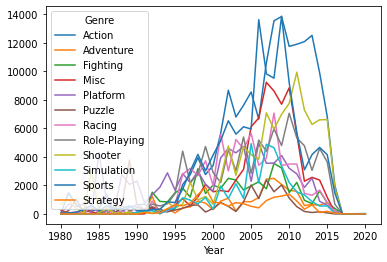

In [21]:
ax = temp.plot()

In [22]:
# t1 = np.arange(0.0, 5.0, 0.01)
# t2 = np.arange(0.0, 5.0, 0.01)

# plt.subplot(221)
# plt.plot(t1, f(t1))

# plt.subplot(222)
# plt.plot(t2, g(t2))

# plt.subplot(223)
# plt.plot(t1, f(t1), 'r-')

# plt.subplot(224)
# plt.plot(t2, g(t2), 'r-')

# plt.show()
temp.columns

Index(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'],
      dtype='object', name='Genre')